# Movie Recommendation Model Training

In [18]:
import os 
from collections import defaultdict
import logging
import time
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from movie_dataset import MovieDataset
# from torch.utils.data import Dataset


## Load the data

In [2]:
# Get the parent directory
parent_dir = os.path.dirname(os.getcwd())
# Construct the data path
data_path = os.path.join(parent_dir, 'data')

df_train = pd.read_csv(os.path.join(data_path, 'df_train.csv'))
df_test = pd.read_csv(os.path.join(data_path, 'df_test.csv'))

## Define the dataloader

In [3]:
genres_cols = ['action', 'adventure', 'animation', 'children', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'film_noir', 'horror', 'imax', 'musical', 'mystery', 'romance', 'sci_fi', 'thriller', 'war', 'western']

In [4]:
users_train = df_train['user_id'].values
movies_train = df_train['movie_id'].values
genres_train = df_train[genres_cols].values
ratings_train = df_train['label'].values

# Create the MovieDataset
train_dataset = MovieDataset(users_train, movies_train, genres_train, ratings_train)

users_test = df_test['user_id'].values
movies_test = df_test['movie_id'].values
genres_test = df_test[genres_cols].values
ratings_test = df_test['label'].values

# Create the MovieDataset
valid_dataset = MovieDataset(users_test, movies_test, genres_test, ratings_test)


In [5]:
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=1)

## Model Definition

The model embeddings learn to capture the latent (hidden) features of users and movies. For instance, in the movie space, embeddings might capture genres, while in the user space, they might capture preferences. This is essentially a form of collaborative filtering, as the model learns from user-item interactions.

As the model trains, user and movie embeddings are adjusted to minimise the prediction error. This means that users who have rated movies similarly will end up having similar embeddings. The same goes for movies that have been rated similarly by users. Therefore, the embeddings are learning the collaborative filtering aspect implicitly.

In [6]:
class RecommendationSystemModel(nn.Module):
    def __init__(
        self,
        num_users,
        num_movies,
        num_genres,
        embedding_size=256,
        hidden_dim=256,
        dropout_rate=0.2,
    ):
        super().__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.num_genres = num_genres
        self.embedding_size = embedding_size
        self.hidden_dim = hidden_dim

        # Embedding layers
        self.user_embedding = nn.Embedding(
            num_embeddings=self.num_users, embedding_dim=self.embedding_size
        )
        self.movie_embedding = nn.Embedding(
            num_embeddings=self.num_movies, embedding_dim=self.embedding_size
        )

        # Hidden layers
        self.fc1 = nn.Linear(2 * self.embedding_size + self.num_genres, self.hidden_dim)
        self.fc2 = nn.Linear(self.hidden_dim, 1)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, users, movies, genres):
        # Embeddings
        user_embedded = self.user_embedding(users)
        movie_embedded = self.movie_embedding(movies)

        # Concatenate user and movie embeddings
        combined = torch.cat([user_embedded, movie_embedded, genres], dim=1)

        # Pass through hidden layers with ReLU activation and dropout
        x = self.relu(self.fc1(combined))
        x = self.dropout(x)
        output = self.fc2(x)

        return output

In [7]:
n_users = pd.concat([df_train, df_test])['user_id'].nunique()
n_movies = pd.concat([df_train, df_test])['movie_id'].nunique()
n_genres = len(genres_cols)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cpu


In [9]:
recommendation_model = RecommendationSystemModel(
    num_users=n_users,
    num_movies=n_movies,
    num_genres=n_genres,
    embedding_size=128,
    hidden_dim=256,
    dropout_rate=0.1,
).to(device)

In [10]:
optimizer = torch.optim.Adam(recommendation_model.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [11]:
EPOCHS = 2

In [12]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [13]:
# Function to log progress
def log_progress(epoch, step, total_loss, log_progress_step, data_size, losses):
    avg_loss = total_loss / log_progress_step
    logger.info(
        f"Epoch: {epoch+1}/{EPOCHS} | Step: {step}/{data_size * EPOCHS} | "
        f"Avg Loss: {avg_loss:.6f}"
    )

    losses.append((step, avg_loss))

In [14]:
total_loss = 0
log_progress_step = 100
log_val_step = 2000
losses = []
val_losses = []
train_dataset_size = len(train_dataset)
print(f"Training on {train_dataset_size} samples...")

Training on 82141 samples...


In [15]:
recommendation_model.train()
start_time = time.time()
step_count = 0
log_step = 0
val_step = 0
for e in range(EPOCHS):
    for i, train_data in enumerate(train_loader):
        output = recommendation_model(
            train_data["users"].to(device), train_data["movies"].to(device), train_data["genres"].to(device)
        )
        # Reshape the model output to match the target's shape
        output = output.squeeze()  # Removes the singleton dimension
        ratings = (
            train_data["ratings"].to(torch.float32).to(device)
        )  # Assuming ratings is already 1D

        loss = loss_func(output, ratings)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Increment step count by the actual size of the batch
        step_count += len(train_data["users"])
        log_step += len(train_data["users"])
        val_step += len(train_data["users"])

        # Check if it's time to log progress
        if (
            log_step % log_progress_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            log_progress(
                e, step_count, total_loss, log_step, train_dataset_size, losses
            )
            log_step = 0
            total_loss = 0

        if (
            val_step % log_val_step == 0 or i == len(train_loader) - 1
        ):  # Log at the end of each epoch
            # Evaluate on validation dataset
            recommendation_model.eval()  # Set the model to evaluation mode
            val_loss = 0
            with torch.no_grad():  # Disable gradient calculation
                for val_data in val_loader:
                    val_output = recommendation_model(
                        val_data["users"].to(device), val_data["movies"].to(device), val_data["genres"].to(device)
                    )
                    val_output = val_output.squeeze()
                    val_ratings = val_data["ratings"].to(torch.float32).to(device)
                    val_loss += loss_func(val_output, val_ratings).sum().item()

            avg_val_loss = val_loss / len(valid_dataset)
            val_losses.append((step_count, avg_val_loss))
            logger.info(f"Epoch: {e+1}/{EPOCHS} | Step: {step_count}/{train_dataset_size * EPOCHS} | Validation Loss: {avg_val_loss:.6f}")

        recommendation_model.train()

INFO:__main__:Epoch: 1/2 | Step: 800/164282 | Avg Loss: 0.209286
INFO:__main__:Epoch: 1/2 | Step: 1600/164282 | Avg Loss: 0.057196
INFO:__main__:Epoch: 1/2 | Step: 2400/164282 | Avg Loss: 0.041748
INFO:__main__:Epoch: 1/2 | Step: 3200/164282 | Avg Loss: 0.034916
INFO:__main__:Epoch: 1/2 | Step: 4000/164282 | Avg Loss: 0.039694
INFO:__main__:Epoch: 1/2 | Step: 4000/164282 | Validation Loss: 0.034749
INFO:__main__:Epoch: 1/2 | Step: 4800/164282 | Avg Loss: 0.036398
INFO:__main__:Epoch: 1/2 | Step: 5600/164282 | Avg Loss: 0.035511
INFO:__main__:Epoch: 1/2 | Step: 6400/164282 | Avg Loss: 0.032293
INFO:__main__:Epoch: 1/2 | Step: 7200/164282 | Avg Loss: 0.032718
INFO:__main__:Epoch: 1/2 | Step: 8000/164282 | Avg Loss: 0.031174
INFO:__main__:Epoch: 1/2 | Step: 8000/164282 | Validation Loss: 0.032079
INFO:__main__:Epoch: 1/2 | Step: 8800/164282 | Avg Loss: 0.032484
INFO:__main__:Epoch: 1/2 | Step: 9600/164282 | Avg Loss: 0.034770
INFO:__main__:Epoch: 1/2 | Step: 10400/164282 | Avg Loss: 0.033

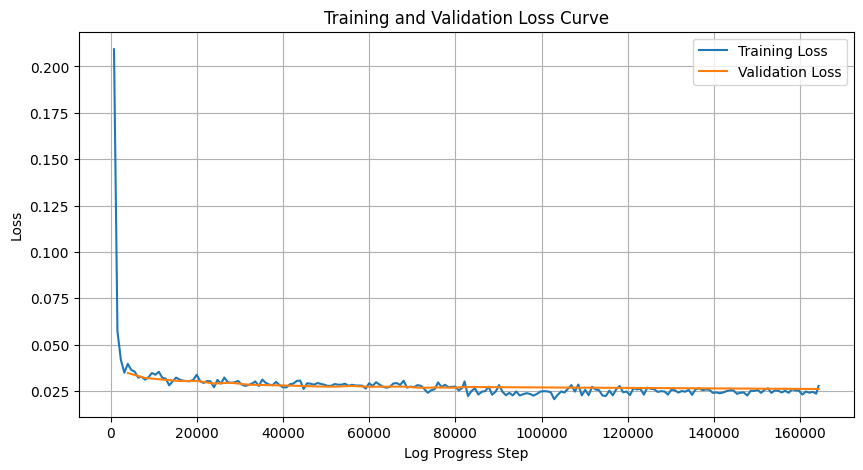

In [16]:
import matplotlib.pyplot as plt

# After the training loop
plt.figure(figsize=(10, 5))
# Unpack the step and loss values for plotting
train_steps, train_loss_values = zip(*losses)
val_steps, val_loss_values = zip(*val_losses)

plt.plot(train_steps, train_loss_values, label='Training Loss')
plt.plot(val_steps, val_loss_values, label='Validation Loss')

plt.xlabel('Log Progress Step')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation

### Precision and Recall

Precision and recall are metrics used to evaluate the relevance of the recommendations. In the context of recommender systems, precision measures the proportion of recommended items in the top-k set that are relevant, while recall measures the proportion of relevant items found in the top-k recommendations. Here’s how these are calculated:

In [19]:
def calculate_precision_recall(user_ratings, k, threshold):
    user_ratings.sort(key=lambda x: x[0], reverse=True)
    n_rel = sum(true_r >= threshold for _, true_r in user_ratings)
    n_rec_k = sum(est >= threshold for est, _ in user_ratings[:k])
    n_rel_and_rec_k = sum((true_r >= threshold) and (est >= threshold) for est, true_r in user_ratings[:k])

    precision = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1
    recall = n_rel_and_rec_k / n_rel if n_rel != 0 else 1
    return precision, recall

In [21]:
user_ratings_comparison = defaultdict(list)

with torch.no_grad():
    for valid_data in val_loader:
        users = valid_data["users"].to(device)
        movies = valid_data["movies"].to(device)
        genres = valid_data["genres"].to(device)
        ratings = valid_data["ratings"].to(device)
        output = recommendation_model(users, movies, genres)

        for user, pred, true in zip(users, output, ratings):
            user_ratings_comparison[user.item()].append((pred[0].item(), true.item()))

In [25]:
user_precisions = dict()
user_based_recalls = dict()

k = 25
threshold = 3

for user_id, user_ratings in user_ratings_comparison.items():
    precision, recall = calculate_precision_recall(user_ratings, k, threshold)
    user_precisions[user_id] = precision
    user_based_recalls[user_id] = recall


average_precision = sum(prec for prec in user_precisions.values()) / len(user_precisions)
average_recall = sum(rec for rec in user_based_recalls.values()) / len(user_based_recalls)

print(f"precision @ {k}: {average_precision:.4f}")
print(f"recall @ {k}: {average_recall:.4f}")

precision @ 25: 0.8984
recall @ 25: 0.7182


### Predicting Top Movies a User Hasn’t Seen

We can now predict a user's top movies that they haven't seen yet. This process involves analyzing their viewing history and preferences.

In [29]:
df_movies = pd.read_csv(os.path.join(data_path, 'all_movies_data.csv'))

In [45]:
# Create a dictionary mapping movie_id to a list of genre values
movie_genres_dict = df_movies.groupby('movie_id')[genres_cols].apply(lambda x: x.iloc[0].tolist()).to_dict()

In [51]:
def recommend_top_movies(
        model: nn.Module,
        user_id: int,
        all_movies: list,
        seen_movies: set,
        movie_genres: dict,
        device: str,
        k: int = 10,
        batch_size: int = 64) -> list:
    """
    Recommend top movies for a user that they haven't seen yet.

    Args:
        model (nn.Module): The trained recommendation model.
        user_id (int): The ID of the user for whom to recommend movies.
        all_movies (list): List of all movie IDs.
        seen_movies (set): Set of movie IDs that the user has already seen.
        movie_genres (dict): Dictionary mapping movie IDs to their genre vectors.
        device (str): The device to run the model on ('cpu' or 'cuda').
        k (int, optional): Number of top recommendations to return. Defaults to 5.
        batch_size (int, optional): Batch size for processing. Defaults to 100.

    Returns:
        list: List of recommended movie IDs.
    """
    model.eval()
    unseen_movies = [m for m in all_movies if m not in seen_movies]
    predictions = []

    if not unseen_movies:
        return []

    with torch.no_grad():
        for i in range(0, len(unseen_movies), batch_size):
            batch_unseen_movies = unseen_movies[i:i+batch_size]
            user_tensor = torch.tensor([user_id] * len(batch_unseen_movies)).to(device)
            movie_tensor = torch.tensor(batch_unseen_movies).to(device)
            genres_tensor = torch.tensor([movie_genres[movie_id] for movie_id in batch_unseen_movies]).to(device)
            predicted_ratings = model(user_tensor, movie_tensor, genres_tensor).view(-1).tolist()
            predictions.extend(zip(batch_unseen_movies, predicted_ratings))

    predictions.sort(key=lambda x: x[1], reverse=True)
    top_k_movies = [movie_id for movie_id, _ in predictions[:k]]
    return top_k_movies

In [52]:
# Prepare all_movies and seen_movies
all_movies = df_movies['movie_id'].unique().tolist()
user_id = 1 # A random userId
seen_movies = set(df_movies[df_movies['user_id'] == user_id]['movie_id'].tolist())

In [53]:
# Get recommendations
recommendations = recommend_top_movies(
    recommendation_model, user_id, all_movies, seen_movies, movie_genres_dict, device
)

In [59]:
recommended_movies = df_movies[df_movies['movie_id'].isin(recommendations)]['title'].unique().tolist()

In [71]:
user_top_ten_seen_movies = df_movies[df_movies['user_id'] == user_id].sort_values(by="label", ascending=False)['title'].unique().tolist()[:5]

In [72]:
user_top_ten_seen_movies

['Inside Job (2010)',
 'Step Brothers (2008)',
 'Wolf of Wall Street, The (2013)',
 'Mad Max: Fury Road (2015)',
 'Warrior (2011)']

In [76]:
print(f"User {user_id} has seen {len(seen_movies)} movies")
print("Based on the top rated movies seen by the user:\n")
for m in user_top_ten_seen_movies:
    print(m)


print("\n\nThe top 10 recommended movies:\n")
for m in recommended_movies:
    print(m)



User 1 has seen 29 movies
Based on the top rated movies seen by the user:

Inside Job (2010)
Step Brothers (2008)
Wolf of Wall Street, The (2013)
Mad Max: Fury Road (2015)
Warrior (2011)


The top 10 recommended movies:

Monty Python and the Holy Grail (1975)
Star Wars: Episode VI - Return of the Jedi (1983)
Rear Window (1954)
Mary and Max (2009)
There Will Be Blood (2007)
Heidi Fleiss: Hollywood Madam (1995)
The Blue Planet (2001)
Scorpio (1973)
Waiting for 'Superman' (2010)
Victory (a.k.a. Escape to Victory) (1981)
